# Fault detection in a stormwater system

In [1]:
# Library imports.
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.animation as animation
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.fft import fft, fftfreq
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mutual_info_score
import seaborn as sns
from typing import Dict, List
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from botorch.acquisition import LogExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood

# UrbanSurge imports.
from urbansurge.swmm_model import SWMM
from urbansurge import swmm_model
from urbansurge.analysis_tools import perturb_storm_arrival, perturb_storm_magnitude, split_storms, combine_storms, generate_runoff
from urbansurge.data_acquisition import flow_to_swmm_readable

# Autoreload.
%load_ext autoreload
%autoreload 2

## Configurations

In [46]:
# File directory for saving figures.
fig_savefp = Path(r'C:\Users\ay434\Box\Research\Smart_Stormwater\Presentations\2025-02-25 EFMH\Figures')

# SWMM configuration path. 
swmm_config_path = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\lab_conduits_config.yml"

# Colorscheme.
cNF = '#d6977e'
cF = '#9cc4b2'

# Fault free weir values.
wH_no_fault = [1, 1, 1, 1]

# Physical system weir values.
wH_phy_no_fault = [0.914, 0.870, 0.943, 0.937]

# Physical system with fault weir values.
wH_phy_fault = [0.914, 0.870, 0.622, 0.937]

# Fault free diameter values.
dH_no_fault = [0, 0, 0, 0]

# Physical system diameter values.
dH_phy_no_fault = [0.0990, 0.0517, 0.0311, 0.0376]
dH_phy_no_fault = [0, 0, 0, 0]

# Physical system with fault weir values.
dH_phy_fault = [0.0, 0.5, 0.0, 0.0]

# Sensor links.
sensor_links = [21, 48]

## Runoff

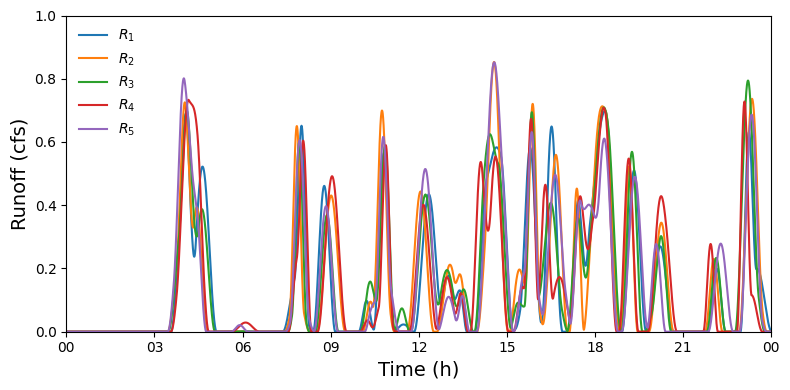

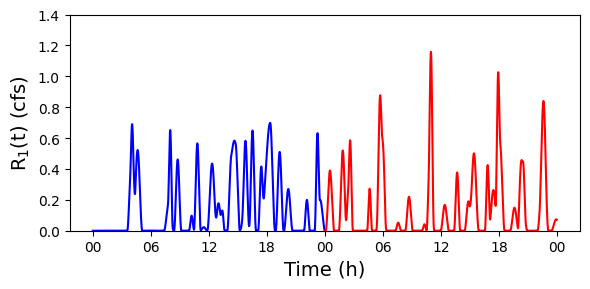

In [3]:
# Generate runoff time series.
dt = 10
T = 1
n_pulse = 30 * T
a_bounds = (0.001, 0.7)
L_bounds = (60 * 30, 60 * 60)
sig_a = 0.05
sig_L = 500
sig_imp = 250
n_runoff = 5
seed = 10

# Runoff 1.
R1, t = generate_runoff(dt, T, n_pulse, a_bounds, L_bounds, sig_a, sig_L, sig_imp, n_runoff, seed)

# Runoff 2.
seed = 30
R2, t = generate_runoff(dt, T, n_pulse, a_bounds, L_bounds, sig_a, sig_L, sig_imp, n_runoff, seed)

# Time as a datetime object.
t_datetime = [datetime(2020, 1, 1) + timedelta(seconds=i) for i in t]

# fig, axes = plt.subplots(1, 5, figsize=(15,2))
# for i in range(5):
#     axes[i].plot(t_datetime, R1[:,i], label='R1')
#     axes[i].plot(t_datetime, R2[:,i], label='R2')
#     axes[i].set_xlim(t_datetime[0], t_datetime[-1])
#     axes[i].set_ylim(0, 0.8)
#     # plt.plot(t_datetime, R2, label='R2')
# plt.legend(frameon=False)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(t_datetime, R1)
ax.legend(['$R_1$', '$R_2$', '$R_3$', '$R_4$', '$R_5$'], frameon=False)
ax.set_xlabel('Time (h)', fontsize=14)
ax.set_ylabel('Runoff (cfs)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=10)
myFmt = mdates.DateFormatter('%H')
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlim([t_datetime[0], t_datetime[-1] + timedelta(seconds=10)]) 
ax.set_ylim([0, 1]) 
fig.tight_layout()
# fig.savefig(fig_savefp / 'R1.png', dpi=300)

fig, ax = plt.subplots(figsize=(6,3))
ax.plot(t_datetime, R1[:,0], 'b')
ax.plot([t_datetime[-1] + timedelta(seconds=dt*i) for i in range(len(t_datetime))], R2[:,0], 'r')
# ax.legend(['$R_{1,1}$', '$R_{2,1}$'], frameon=False)
ax.set_xlabel('Time (h)', fontsize=14)
ax.set_ylabel('$\\rm R_1(t)$ (cfs)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=10)
myFmt = mdates.DateFormatter('%H')
ax.xaxis.set_major_formatter(myFmt)
# ax.set_xlim([t_datetime[0], t_datetime[-1] + timedelta(seconds=10)]) 
ax.set_ylim([0, 1.4]) 
fig.tight_layout()
fig.savefig(fig_savefp / 'concat_runoff.png', dpi=300)

#### Save/Load impulses

In [4]:
def save_impulses_to_swmm(R, t_datetime):
    # Impulse directory.
    impulse_dir = Path(r'C:\Users\ay434\Documents\urbansurge\analysis\lab_system\precipitation\precip_data\paper3_exp')

    # Impulse files corresponding to each node. {Node: Impulse filename}
    impulse_files = {
        '46': 'R46',
        '44': 'R44',
        '42': 'R42',
        '40': 'R40',
        '38': 'R38',
    }

    c = 0
    for node, fname in impulse_files.items():
        flow_to_swmm_readable(R[:,c].flatten(), t_datetime, impulse_dir, f'{fname}.dat')
        c += 1

### Run model with weirs

In [5]:
def run_model_with_weirs(swmm, wH):
    # Configure model.
    swmm.configure_model()

    # Set the weir heights.
    weir_height_P = {
        19: wH[0],
        20: wH[1],
        21: wH[2],
        22: wH[3]
    }

    for weir, height in weir_height_P.items():
        geom = swmm.get_weir_geometry(weir)
        geom[1] = height
        swmm.set_weir_geometry(weir, geom)

    # Run model.
    swmm.run_simulation()

    # Sensor depth, velocity, and flow.
    depth = swmm.get_link_depth()
    velocity = swmm.get_link_velocity()
    flow = swmm.get_link_flow()

    # Set 'datetime' as index.
    depth.set_index('datetime', inplace=True)
    velocity.set_index('datetime', inplace=True)
    flow.set_index('datetime', inplace=True)

    # Concatenate along the column axis.
    sensor_data = pd.concat([depth, velocity, flow], axis=1).reset_index()

    return sensor_data


def run_model_with_constrictions(swmm_config_path, dH, sensor_links):
    # SWMM model.
    swmm = SWMM(swmm_config_path)

    # Configure model.
    swmm.configure_model()

    # Discretize links.
    n_segment = 6
    link_ids = [14, 15, 16, 17, 18]
    for link_id in link_ids:
        swmm.discretize_link(link_id, n_segment)

    # Set the weir heights.
    diameter_vals = {
        1: dH[0],
        2: dH[1],
        3: dH[2],
        4: dH[3]
    }

    for link, diameter in diameter_vals.items():
        swmm_model.diameter_fault(swmm, link, diameter, 'absolute')

    # Run model.
    swmm.run_simulation()

    # Sensor depth, velocity, and flow.
    depth = swmm.get_link_depth()
    velocity = swmm.get_link_velocity()
    flow = swmm.get_link_flow()
    flooding = swmm.get_node_flooding()

    # Set 'datetime' as index.
    depth.set_index('datetime', inplace=True)
    velocity.set_index('datetime', inplace=True)
    flow.set_index('datetime', inplace=True)
    flooding.set_index('datetime', inplace=True)

    # Concatenate along the column axis.
    sensor_data = pd.concat([depth, velocity, flow, flooding], axis=1).reset_index()

    # Only keep sensor links.
    keep_col_template = [f'link_{ID}' for ID in sensor_links]

    keep_cols = []
    for state in ['Depth', 'Flow', 'Velocity']:
        keep_cols.extend([f'{state}_{c}' for c in keep_col_template])

    # Drop columns that contain 'link' but are not in the keep list
    sensor_data_filtered = sensor_data[[col for col in sensor_data.columns if 'link' not in col or col in keep_cols]]

    return sensor_data_filtered

## Physical System

In [6]:
# Save measured impulse to swmm.
save_impulses_to_swmm(R1, t_datetime)

# Concatenate along the column axis.
sensor_data_1_P = run_model_with_constrictions(swmm_config_path, dH_phy_no_fault, sensor_links)

Simulation info
Flow Units: CFS
System Units: US
Start Time: 2020-01-01 00:00:00
Start Time: 2020-01-02 06:00:00
Removed Line: 14               38               39               100        0.03       0          0          0          0         

Removed Line: 14               CIRCULAR     1                0          0          0          1                    

Removed Line: 15               40               41               100        0.03       0          0          0          0         

Removed Line: 15               CIRCULAR     1                0          0          0          1                    

Removed Line: 16               42               43               100        0.03       0          0          0          0         

Removed Line: 16               CIRCULAR     1                0          0          0          1                    

Removed Line: 17               44               45               100        0.03       0          0          0          0         

Removed 

## Modeled System

### Residuals with best estimate of runoff

In [8]:
# ECDF of best measurements of runoff.
sig_t = 60 * 10
sig_m = 0.1
S, St = split_storms(R1, t)
Sp, Stp = perturb_storm_arrival(S, St, t, sig_t)
Sp, Stp = perturb_storm_magnitude(Sp, Stp, t, sig_m)
R1m = combine_storms(Sp, Stp, t)

# Save measured impulse to swmm.
save_impulses_to_swmm(R1m, t_datetime)

# # Concatenate along the column axis.
# sensor_data_1_M = run_model_with_weirs(swmm, wH_no_fault)

# # Model residuals and eCDF.
# residuals = sensor_data_1_M['Depth_link_18'].to_numpy() - sensor_data_1_P['Depth_link_18'].to_numpy()
# x_best = np.sort(residuals.flatten())
# y_best = np.arange(len(x_best))/float(len(x_best))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

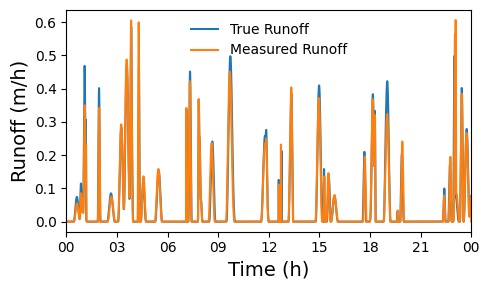

In [26]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(t_datetime, R1, label='True Runoff')
ax.plot(t_datetime, R1m, label='Measured Runoff')
ax.set_xlabel('Time (h)', fontsize=14)
ax.set_ylabel('Runoff (m/h)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=10)
myFmt = mdates.DateFormatter('%H')
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlim([t_datetime[0], t_datetime[-1] + timedelta(seconds=10)]) 
# ax.set_ylim([0, 0.14]) 
ax.legend(frameon=False)   
fig.tight_layout()
# fig.savefig(fig_savefp / 'R1.png', dpi=300)

## Second set of runoff.

In [32]:
# Best measurement of runoff.
sig_t = 60 * 100
sig_m = 0.1
S, St = split_storms(R2, t)
Sp, Stp = perturb_storm_arrival(S, St, t, sig_t)
Sp, Stp = perturb_storm_magnitude(Sp, Stp, t, sig_m)
R2m = combine_storms(Sp, Stp, t)

# Time as a datetime object.
t_datetime = [datetime(2020, 1, 1) + timedelta(seconds=i) for i in t]

plt.plot(t_datetime, R2)
plt.plot(t_datetime, R2m)
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### Physical system

In [47]:
# Save measured impulse to swmm.
save_impulses_to_swmm(R1, t_datetime)

# Weir values with no faults.
sensor_data_1_P_F = run_model_with_constrictions(swmm_config_path, dH_phy_fault, sensor_links)

Simulation info
Flow Units: CFS
System Units: US
Start Time: 2020-01-01 00:00:00
Start Time: 2020-01-02 06:00:00
Removed Line: 14               38               39               100        0.03       0          0          0          0         

Removed Line: 14               CIRCULAR     1                0          0          0          1                    

Removed Line: 15               40               41               100        0.03       0          0          0          0         

Removed Line: 15               CIRCULAR     1                0          0          0          1                    

Removed Line: 16               42               43               100        0.03       0          0          0          0         

Removed Line: 16               CIRCULAR     1                0          0          0          1                    

Removed Line: 17               44               45               100        0.03       0          0          0          0         

Removed 

### Utility functions

In [191]:
def extract_recessions(S: np.ndarray, norm=False) -> Dict[int, List[float]]:
    """
    Extracts all the falling limbs from a hydrograph time series.

    :param S: Hydrograph time series.
    :type S: np.ndarray
    :return: Dictionary containing all falling limbs, where keys are the indices of the peaks.
    :rtype: Dict[int, List[float]]
    """
    falling_limbs = {}
    i = 0
    while i < len(S) - 1:
        # Find the next peak
        if S[i] > S[i + 1]:
            peak_idx = i
            falling_limb = [S[i]]
            i += 1
            # Collect all monotonically decreasing samples
            while i < len(S) and S[i] <= S[i - 1]:
                falling_limb.append(S[i])
                i += 1
            if norm is True:
                falling_limb = (falling_limb - np.mean(falling_limb)) / np.std(falling_limb)
            falling_limbs[peak_idx] = falling_limb
        else:
            i += 1

    return falling_limbs

def extract_trajectories(Y, r, min_length=10):
    """
    Extracts individual trajectories from Y that start when any sensor value moves outside
    of a ball of radius r centered at the origin and end when all sensors re-enter the ball.

    Parameters:
        Y (numpy.ndarray): A (Nt, Ns) array where Nt is the number of time steps and Ns is the number of sensors.
        r (float): The radius of the ball centered at the origin.
        min_length (int): The minimum trajectory length to be considered.

    Returns:
        dict: A dictionary containing trajectories with keys as indices.
    """
    trajectories = {}
    trajectory_index = 0
    Nt, Ns = Y.shape
    
    outside = np.linalg.norm(Y, axis=1) > r  # Boolean array indicating if any sensor is outside the ball
    in_trajectory = False
    start_idx = None
    
    for t in range(Nt):
        if outside[t]:
            if not in_trajectory:
                in_trajectory = True
                start_idx = t
            elif in_trajectory and t == Nt - 1:
                end_idx = t
                trajectories[trajectory_index] = Y[start_idx:end_idx]
        else:
            if in_trajectory or t == Nt - 1:
                end_idx = t
                if end_idx - start_idx >= min_length:
                    trajectories[trajectory_index] = Y[start_idx:end_idx]
                    trajectory_index += 1
                in_trajectory = False
    
    return trajectories


def fit_linear_regression(data):
    if data.shape[0] == 0:  # Handle empty case
        return None

    X = data[:, 0].reshape(-1, 1)  # Independent variable
    y = data[:, 1]  # Dependent variable

    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)

    residuals_projected = compute_ortho_residuals(data, model)

    return model, residuals_projected

def compute_ortho_residuals(data, model):
    X = data[:, 0].reshape(-1, 1)  # Independent variable
    y = data[:, 1]  # Dependent variable

    # Get slope and intercept
    slope = model.coef_[0]

    # Compute predictions
    y_pred = model.predict(X)

    # Compute residuals (y component)
    residuals_y = y - y_pred

    # Compute unit vector along the fitted line
    direction_vector = np.array([1, slope])  # A step of 1 in x moves 'slope' in y
    direction_vector /= np.linalg.norm(direction_vector)  # Normalize to unit length

    # Compute the perpendicular vector to the fitted line
    perpendicular_vector = np.array([-direction_vector[1], direction_vector[0]])  # Rotate 90 degrees

    # Project residuals onto the perpendicular vector
    residuals_projected = residuals_y * perpendicular_vector[1]  # Only consider y-component

    return residuals_projected

# Manning's equation.
def manning_velocity(swmm, d, D, n, S, a=1.49):
    Rh = swmm.get_link_circular_Rh(d, D)
    v = (a / n) * S**(1 / 2) * Rh**(2 / 3)

    return v

### Residuals

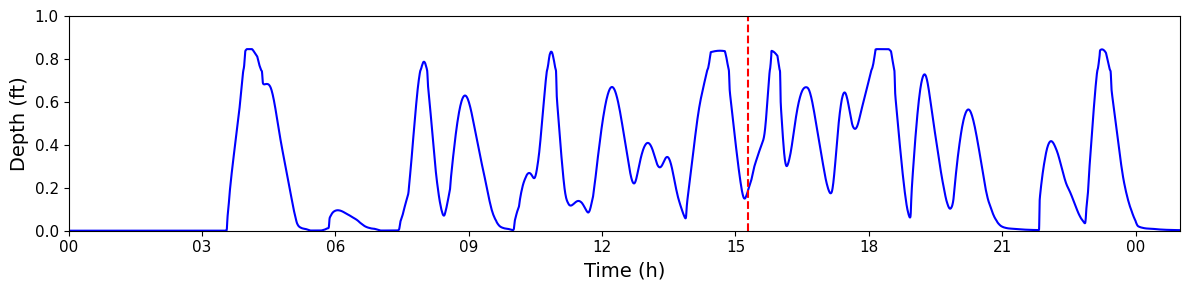

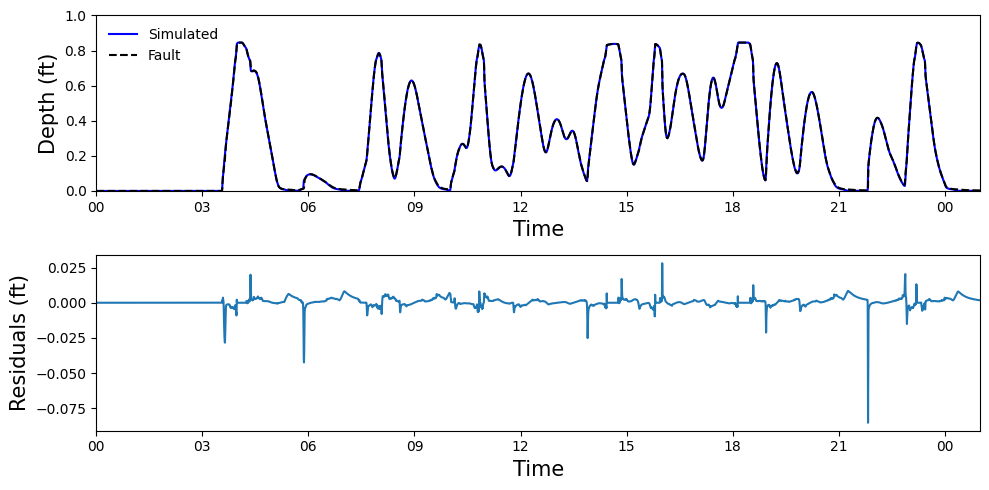

In [48]:
fault_start_idx = 5500
variable = 'Depth'
sP = sensor_data_1_P[f'{variable}_link_{sensor_links[1]}'].to_numpy()
sF = sensor_data_1_P_F[f'{variable}_link_{sensor_links[1]}'].to_numpy()
concat_fault_data = np.concatenate([sP[:fault_start_idx], sF[fault_start_idx:]])

fig, ax = plt.subplots(figsize=(12,3))
# ax2 = ax.twinx()
ax.plot(sensor_data_1_P['datetime'], concat_fault_data, c='b')
# ax2.plot(sensor_data_1_P['datetime'], sP, c='k')
# ax2.plot(sensor_data_1_P['datetime'], sF)
# # Residuals.
# ax.plot(sensor_data_1_P['datetime'], sP - sF, c='r')
# Noise floor.
# ax.axhline(0.05, c='r', linestyle='--')
# ax.axhline(-0.05, c='r', linestyle='--')
ax.axvline(sensor_data_1_P['datetime'].iloc[fault_start_idx], c='r', linestyle='--')
ax.set_xlim([sensor_data_1_P['datetime'].iloc[0] - timedelta(seconds=10), t_datetime[-1] + timedelta(hours=1)])
# ax.set_xlim([sensor_data_1_P['datetime'].iloc[1000], sensor_data_1_P['datetime'].iloc[2000]])
ax.set_ylim([0, 1])
myFmt = mdates.DateFormatter('%H')
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel('Time (h)', fontsize=14)
ax.set_ylabel(f'{variable} (ft)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=11)

fig.tight_layout()
# fig.savefig(fig_savefp / 'guess_the_fault_depth_soln.png', dpi=300)

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,5))
ax1.plot(sensor_data_1_P['datetime'], sP, c='b', label='Simulated')
ax1.plot(sensor_data_1_P['datetime'], sF, 'k--', label='Fault')
ax1.xaxis.set_major_formatter(myFmt)
ax1.set_xlim([sensor_data_1_P['datetime'].iloc[0] - timedelta(seconds=10), t_datetime[-1] + timedelta(hours=1)])
ax1.set_ylim([0, 1])
ax1.set_xlabel('Time', fontsize=15)
ax1.set_ylabel('Depth (ft)', fontsize=15)
ax1.legend(frameon=False)

ax2.plot(sensor_data_1_P['datetime'], sF - sP)
ax2.xaxis.set_major_formatter(myFmt)
ax2.set_xlim([sensor_data_1_P['datetime'].iloc[0] - timedelta(seconds=10), t_datetime[-1] + timedelta(hours=1)])
ax2.set_xlabel('Time', fontsize=15)
ax2.set_ylabel('Residuals (ft)', fontsize=15)

fig.tight_layout()
# fig.savefig(fig_savefp / 'residual_comparison_0.75.png', dpi=300)




Simulation info
Flow Units: CFS
System Units: US
Start Time: 2020-01-01 00:00:00
Start Time: 2020-01-02 06:00:00


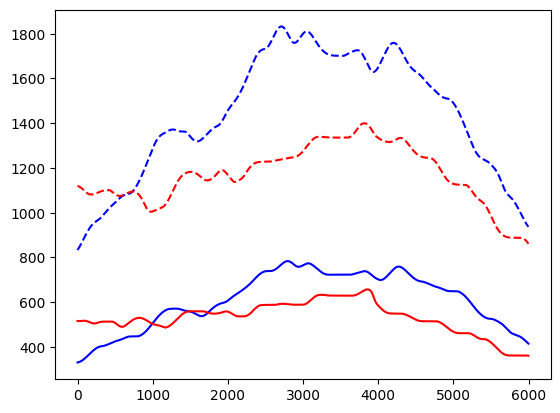

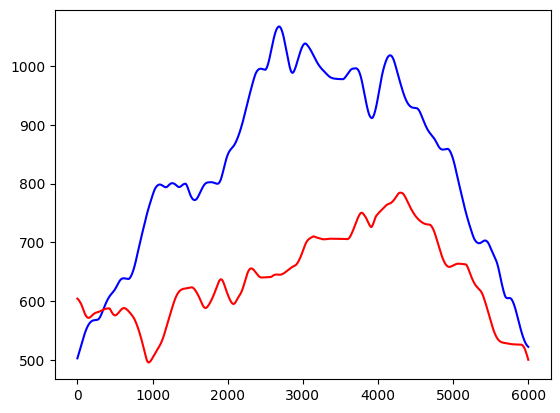

In [237]:
# Volume difference.

t = list(sensor_data_1_P['datetime'])
t_hrs = np.array([(dt - t[0]).total_seconds() / 3600 for dt in t])

# Volume integration time.
T = 12
T_idx = np.argmin(np.abs(t_hrs - T))

# Travel time from sensor 1 to sensor 2.
L = 2012
swmm = SWMM(swmm_config_path)
d = 0.5
D = 1
n = 0.03
S = 0.02
v = manning_velocity(swmm, d, D, n, S, a=1.49)
tau = L / v / 3600

T_m_tau_idx = np.argmin(np.abs(t_hrs - (T - tau)))

# Integrate sensor flows.
Nk = 6000
V1_P = np.zeros(Nk)
V2_P = np.zeros(Nk)

V1_F = np.zeros(Nk)
V2_F = np.zeros(Nk)
for k in range(Nk):
    V1_P[k] = np.sum(sensor_data_1_P[f'{variable}_link_{sensor_links[0]}'].to_numpy()[k:k+T_m_tau_idx]) # Upstream.
    V2_P[k] = np.sum(sensor_data_1_P[f'{variable}_link_{sensor_links[1]}'].to_numpy()[k+(T_idx - T_m_tau_idx):k+T_idx]) # Downstream.

    V1_F[k] = np.sum(sensor_data_1_P_F[f'{variable}_link_{sensor_links[0]}'].to_numpy()[k:k+T_m_tau_idx]) # Upstream.
    V2_F[k] = np.sum(sensor_data_1_P_F[f'{variable}_link_{sensor_links[1]}'].to_numpy()[k+(T_idx - T_m_tau_idx):k+T_idx]) # Downstream.

fig, ax = plt.subplots()
ax.plot(V1_P, 'b-')
ax.plot(V2_P, 'b--')
ax.plot(V1_F, 'r-')
ax.plot(V2_F, 'r--')
# ax.set_xlim(0, 1200)
# ax.set_ylim(0, 1200)

fig, ax = plt.subplots()
ax.plot(V2_P - V1_P, 'b-')
ax.plot(V2_F - V1_F, 'r-')

### Flooding

Simulation info
Flow Units: CFS
System Units: US
Start Time: 2020-01-01 00:00:00
Start Time: 2020-01-02 06:00:00
Removed Line: 14               38               39               100        0.03       0          0          0          0         

Removed Line: 14               CIRCULAR     1                0          0          0          1                    

Removed Line: 15               40               41               100        0.03       0          0          0          0         

Removed Line: 15               CIRCULAR     1                0          0          0          1                    

Removed Line: 16               42               43               100        0.03       0          0          0          0         

Removed Line: 16               CIRCULAR     1                0          0          0          1                    

Removed Line: 17               44               45               100        0.03       0          0          0          0         

Removed 

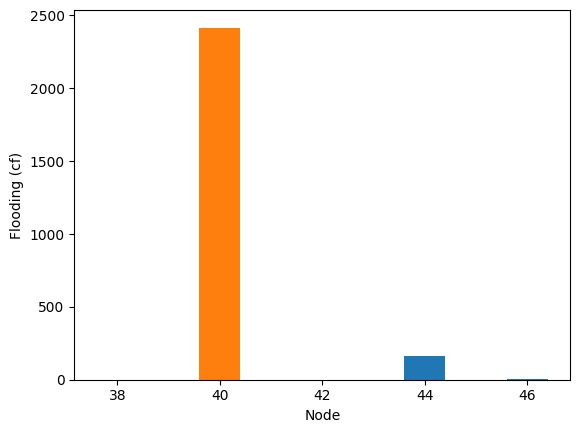

In [179]:
flood_nodes = [38, 40, 42, 44, 46]

flooding_P = np.zeros(len(flood_nodes))
flooding_F = np.zeros(len(flood_nodes))
for i, node in enumerate(flood_nodes):
    flooding_P[i] = np.sum(sensor_data_1_P[f'Flood_node_{node}'])
    flooding_F[i] = np.sum(sensor_data_1_P_F[f'Flood_node_{node}'])

fig, ax = plt.subplots()
ax.bar(flood_nodes, flooding_P)
ax.bar(flood_nodes, flooding_F)
ax.set_xlabel('Node')
ax.set_ylabel('Flooding (cf)')

fault_sevs = np.linspace(0.4, 0.7, 10)
flood_F = np.zeros((len(fault_sevs), len(flood_nodes)))
for i, sev in enumerate(fault_sevs):
    dH_phy_fault = [0, sev, 0, 0]
    sensor_data_1_P_F = run_model_with_constrictions(swmm_config_path, dH_phy_fault, sensor_links)
    for j, node in enumerate(flood_nodes):
        flood_F[i,j] = np.sum(sensor_data_1_P_F[f'Flood_node_{node}'])

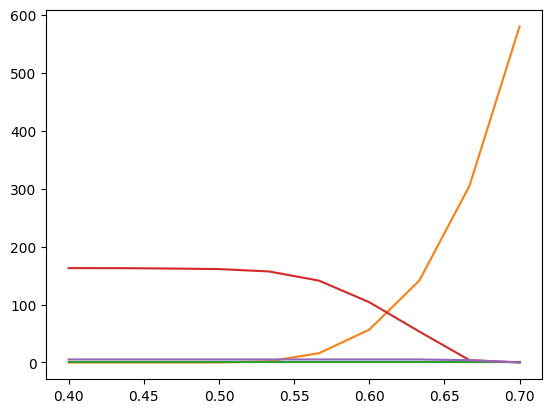

In [180]:
fig, ax = plt.subplots()
ax.plot(fault_sevs, flood_F)

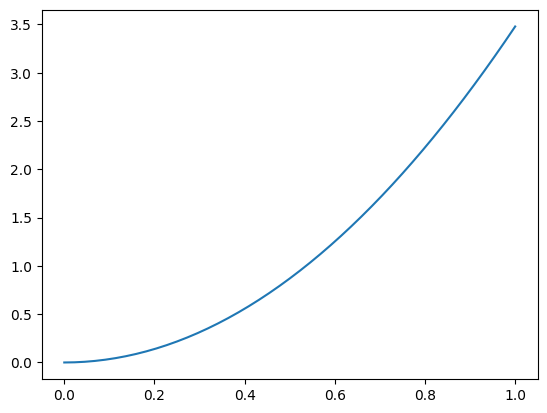

In [181]:
D = np.linspace(0,1,45)
Q = np.sqrt(2 * 9.81) * (np.pi / 4 * D**2)

fig, ax = plt.subplots()
ax.plot(D, Q)

### Simple difference

[]

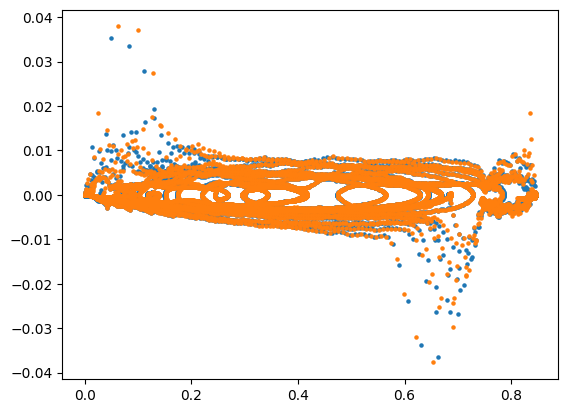

In [268]:
variable = 'Depth'
L1 = 21
L2 = 48

s1P = sensor_data_1_P[f'{variable}_link_{L1}'].to_numpy()
s2P = sensor_data_1_P[f'{variable}_link_{L2}'].to_numpy()
s1F = sensor_data_1_P_F[f'{variable}_link_{L1}'].to_numpy()
s2F = sensor_data_1_P_F[f'{variable}_link_{L2}'].to_numpy()

s2P_diff = np.diff(s2P)
s2F_diff = np.diff(s2F)

# plt.hist(s2P_diff, bins=np.linspace(-0.03, 0.03, 51), alpha=0.4)
# plt.hist(s2F_diff, bins=np.linspace(-0.03, 0.03, 51), alpha=0.4)
# plt.show()

plt.scatter(s2P[1:], s2P_diff, s=5)
plt.scatter(s2F[1:], s2F_diff, s=5)
plt.plot()

### ECDF

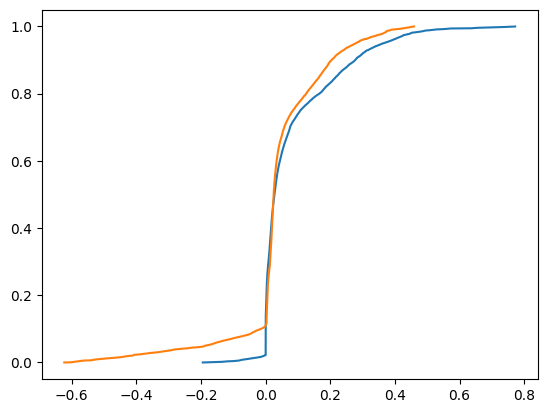

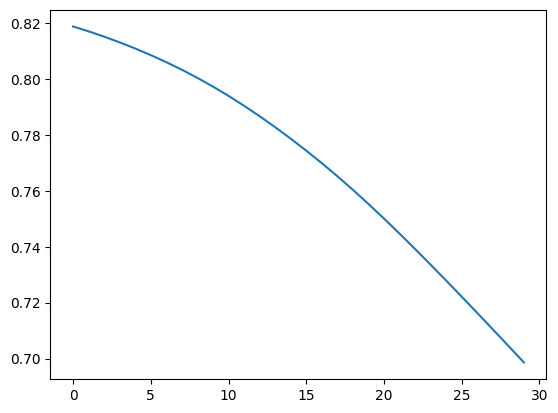

In [74]:
variable = 'Depth'
L1 = 21
L2 = 46

s1P = sensor_data_1_P[f'{variable}_link_{L1}'].to_numpy()
s2P = sensor_data_1_P[f'{variable}_link_{L2}'].to_numpy()
s1F = sensor_data_1_P_F[f'{variable}_link_{L1}'].to_numpy()
s2F = sensor_data_1_P_F[f'{variable}_link_{L2}'].to_numpy()

bin_edges = np.linspace(-0.3, 0.7, 50)
plt.plot(np.sort(s2P - s1P), np.arange(len(s2P)) / len(s2P))
plt.plot(np.sort(s2F - s1F), np.arange(len(s2F)) / len(s2F))
# plt.hist(s2F - s1F, bins=bin_edges, alpha=0.5)
# plt.yscale('log')
plt.show()

max_lag = 30
C = np.zeros(max_lag)
for lag in range(max_lag):
    if lag == 0:
        s1P_lag = s1P
        s2P_lag = s2P
        s1F_lag = s1F
        s2F_lag = s2F
    else:
        s1P_lag = s1P[lag:]
        s2P_lag = s2P[:-lag]
        s1F_lag = s1F[lag:]
        s2F_lag = s2F[:-lag]
    
    C[lag] = np.corrcoef(s1P_lag, s2P_lag)[0, 1]

fig, ax = plt.subplots()
ax.plot(C)

In [14]:
thresh = 0.04
# idxP = (s1P > thresh) & (s2P > thresh)
idxP = np.linalg.norm(np.stack([s1P, s2P]).T, axis=1) < thresh
# idxF = (s1F > thresh) & (s2F > thresh)
idxF = np.linalg.norm(np.stack([s1F, s2F]).T, axis=1) < thresh
# s1P = s1P[idxP]
# s2P = s2P[idxP]
# s1F = s1F[idxF]
# s2F = s2F[idxF]
s1P[idxP] = np.nan
s2P[idxP] = np.nan
s1F[idxF] = np.nan
s2F[idxF] = np.nan
# dtP = sensor_data_1_P['datetime'].iloc[idxP].to_numpy()
# dtF = sensor_data_1_P['datetime'].iloc[idxF].to_numpy()
dtP = sensor_data_1_P['datetime'].to_numpy()
dtF = sensor_data_1_P['datetime'].to_numpy()

print(dtP[2000])
print(dtF[0])

fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(s1P, s2P, s=5, c='b', alpha=0.5, edgecolors="None")
ax.scatter(s1F, s2F, s=5, c='r', alpha=0.5, edgecolors="None")

# ax.scatter(np.cumsum(s1P) / np.arange(len(s1P)), np.cumsum(s2P) / np.arange(len(s2P)), marker='o', c=np.arange(len(s2P)), cmap='Blues')
# ax.scatter(np.cumsum(s1F) / np.arange(len(s1F)), np.cumsum(s2F) / np.arange(len(s2F)), marker='o', c=np.arange(len(s1F)), cmap='Reds')
# ax.plot(np.cumsum(s1P) / np.arange(len(s1P)), np.cumsum(s2P) / np.arange(len(s2P)), c='b', alpha=0.3)
# ax.plot(np.cumsum(s1F) / np.arange(len(s1F)), np.cumsum(s2F) / np.arange(len(s2F)), c='r', alpha=0.3)

# ax.axvline(thresh, c='k', alpha=0.5, linestyle='--')
# ax.axhline(thresh, c='k', alpha=0.5, linestyle='--')

theta = np.linspace(0, 2*np.pi, 300)  # Generate angles from 0 to 2π
xc = (thresh - 0.005) * np.cos(theta)  # X coordinates
yc = (thresh - 0.005) * np.sin(theta)  # Y coordinates
ax.plot(xc, yc, 'k', linewidth=2)

ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
# ax.set_xlim([0, 0.6])
# ax.set_ylim([0, 0.6])

ax.set_xlabel('$d_A$ (ft)', fontsize=15)
ax.set_ylabel('$d_B$ (ft)', fontsize=15)
ax.tick_params(labelsize=12)

fig.tight_layout()
# fig.savefig(fig_savefp / 'R1_F0.75_states.png', dpi=300)
# fig.savefig(fig_savefp / 'R1_F0.75_means.png', dpi=300)

fig, ax = plt.subplots(figsize=(5, 2))
ax.hist(s1P, bins=51, density=True, color='blue', alpha=0.5)
ax.hist(s1F, bins=51, density=True, color='red', alpha=0.5)
ax.set_xlim([0, 1])
# ax.set_xlabel('Depth (ft)', fontsize=15)
# ax.set_ylabel('Density', fontsize=15)
ax.tick_params(labelsize=12)
fig.tight_layout()
fig.savefig(fig_savefp / 's1_hist.png', dpi=300)

fig, ax = plt.subplots(figsize=(5, 2))
ax.hist(s2P, bins=51, density=True, color='blue', alpha=0.5)
ax.hist(s2F, bins=51, density=True, color='red', alpha=0.5)
ax.set_xlim([0, 1])
# ax.set_xlabel('Depth (ft)', fontsize=15)
# ax.set_ylabel('Density', fontsize=15)
ax.tick_params(labelsize=12)
fig.tight_layout()
fig.savefig(fig_savefp / 's2_hist.png', dpi=300)

ValueError: all input arrays must have the same shape

### Fourier transform

(0.0001, 10000.0)

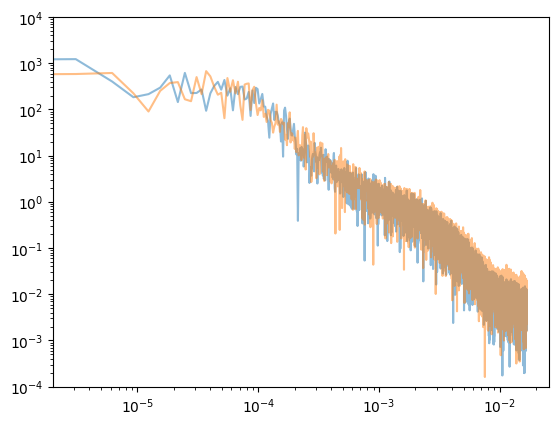

In [258]:
variable = 'Depth'
L1 = 21
L2 = 48

s1P = sensor_data_1_P[f'{variable}_link_{L1}'].to_numpy()
s2P = sensor_data_1_P[f'{variable}_link_{L2}'].to_numpy()
s1F = sensor_data_1_P_F[f'{variable}_link_{L1}'].to_numpy()
s2F = sensor_data_1_P_F[f'{variable}_link_{L2}'].to_numpy()

s1P_fft = np.abs(fft(s1P - np.mean(s1P)))
s1F_fft = np.abs(fft(s1F - np.mean(s1F)))
s2P_fft = np.abs(fft(s2P - np.mean(s2P)))
s2F_fft = np.abs(fft(s2F - np.mean(s2F)))

N = len(s1P)
T = (sensor_data_1_P['datetime'].iloc[-1] - sensor_data_1_P['datetime'].iloc[0]).total_seconds() / 3600
xf = fftfreq(N, T)[:N//2]


fig, ax = plt.subplots()
ax.plot(xf, s2P_fft[:N//2], alpha=0.5)
ax.plot(xf, s2F_fft[:N//2], alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(10e-5, 10e3)

### Linear regression histogram

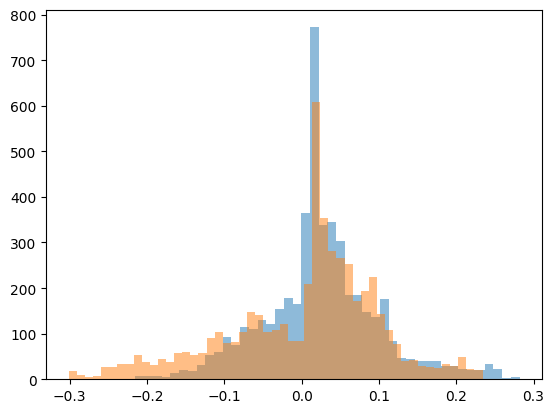

In [537]:
model_P, residuals_P = fit_linear_regression(data_df.loc[:,['s1P', 's2P']].dropna().to_numpy())
residuals_F = compute_ortho_residuals(data_df.loc[:,['s1F', 's2F']].dropna().to_numpy(), model_P)

plt.hist(residuals_P, bins=51, alpha=0.5)
plt.hist(residuals_F, bins=51, alpha=0.5)
plt.show()

### Trajectories

[-4.85364937e-02 -6.62556771e-02 -8.38143525e-02 ... -8.75188758e-05
 -9.08798145e-05 -9.42151561e-05]
[0.04251882 0.05879975 0.07582504 ... 0.00392348 0.00391563 0.00390779]


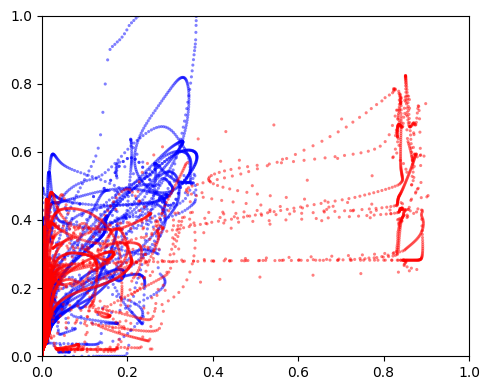

In [75]:
variable = 'Depth'
s1P = sensor_data_1_P[f'{variable}_link_{L1}'].to_numpy()
s2P = sensor_data_1_P[f'{variable}_link_{L2}'].to_numpy()
s1F = sensor_data_1_P_F[f'{variable}_link_{L1}'].to_numpy()
s2F = sensor_data_1_P_F[f'{variable}_link_{L2}'].to_numpy()

YP = np.stack([s1P, s2P]).T
YF = np.stack([s1F, s2F]).T
trajP = extract_trajectories(YP, 0.04)
trajF = extract_trajectories(YF, 0.04)

plt.figure(figsize=(5,4))

traj_list = []
for key, traj in trajP.items():
    # traj = traj / np.max(np.linalg.norm(traj, axis=1))
    traj_list.append(traj)
    plt.scatter(traj[:,0], traj[:,1], s=5, c='b', alpha=0.5, edgecolors="None")
    # plt.scatter(np.argmax(traj[:,0]), np.argmax(traj[:,1]), c='b', edgecolors="None")
traj_all_P = np.vstack(traj_list) if traj_list else np.array([])

traj_list = []
for key, traj in trajF.items():
    # traj = traj / np.max(np.linalg.norm(traj, axis=1))
    traj_list.append(traj)
    plt.scatter(traj[:,0], traj[:,1], s=5, c='r', alpha=0.5, edgecolors="None")
    # plt.scatter(np.argmax(traj[:,0]), np.argmax(traj[:,1]), c='r', edgecolors="None")
traj_all_F = np.vstack(traj_list) if traj_list else np.array([])

plt.xlim([0, 1])
plt.ylim([0, 1])

# Fit models and compute variance of residuals
model_P, var_residuals_P = fit_linear_regression(traj_all_P)
model_F, var_residuals_F = fit_linear_regression(traj_all_F)
print(var_residuals_P)
print(var_residuals_F)

plt.tight_layout()

# plt.savefig(fig_savefp / 'traj_0.0.png', dpi=300)
plt.show()


### Mutual information

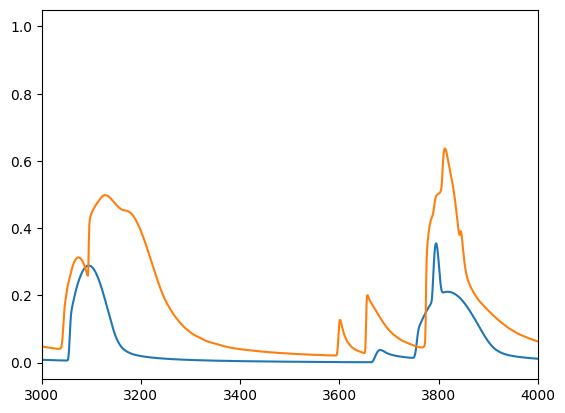

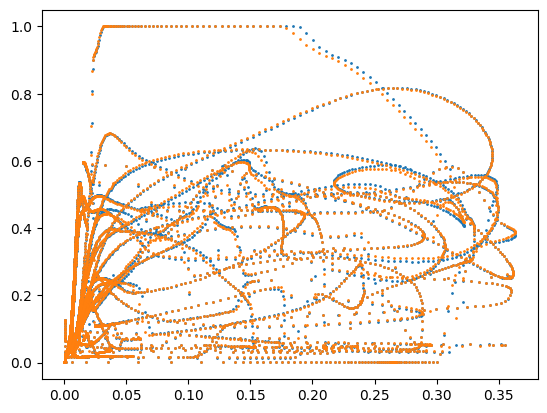

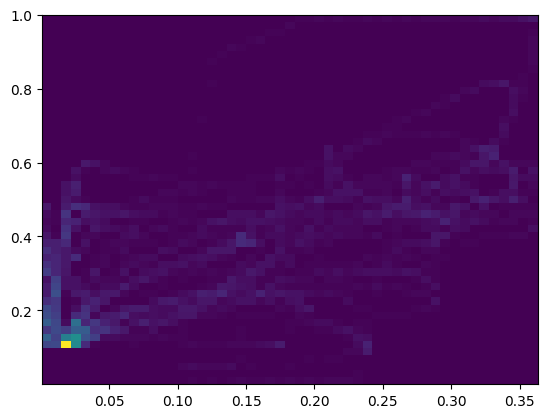

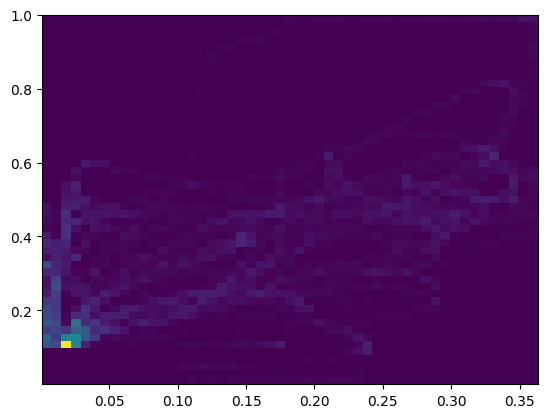

1.2409290056127644 0.7872300945504618
1.239228532325234 0.7979178735860826


In [145]:
variable = 'Depth'
L1 = 23
L2 = 64
s1P = sensor_data_1_P[f'{variable}_link_{L1}'].to_numpy()
s2P = sensor_data_1_P[f'{variable}_link_{L2}'].to_numpy()
s1F = sensor_data_1_P_F[f'{variable}_link_{L1}'].to_numpy()
s2F = sensor_data_1_P_F[f'{variable}_link_{L2}'].to_numpy()

thresh = 0.1
P_pos_idx = (s1P > thresh) | (s2P > thresh)
F_pos_idx = (s1F > thresh) | (s2F > thresh)
s1P_pos = s1P[P_pos_idx]
s2P_pos = s2P[P_pos_idx]
s1F_pos = s1F[F_pos_idx]
s2F_pos = s2F[F_pos_idx]

# Normalize time series.
def norm_series(y): return (y - np.mean(y)) / np.std(y)
s1P_norm = norm_series(s1P_pos)
s2P_norm = norm_series(s2P_pos)
s1F_norm = norm_series(s1F_pos)
s2F_norm = norm_series(s2F_pos)

plt.plot(np.arange(len(s1P)), s1P)
plt.plot(np.arange(len(s1F)), s2P)
plt.xlim(3000, 4000)
plt.show()

lag = 50
plt.scatter(s1P[lag:], s2P[:-lag], s=1)
plt.scatter(s1F[lag:], s2F[:-lag], s=1)
plt.show()

plt.hist2d(s1P_pos, s2P_pos, bins=51)
plt.show()

plt.hist2d(s1F_pos, s2F_pos, bins=51)
plt.show()

def mutual_info(x, y, bins):
    x_binned = np.digitize(x, bins=np.linspace(x.min(), x.max(), bins))
    y_binned = np.digitize(y, bins=np.linspace(y.min(), y.max(), bins))

    # Compute Mutual Information
    mi_score = mutual_info_score(x_binned, y_binned)

    # Mutual information regression.
    mi_continuous = mutual_info_regression(x.reshape(-1, 1), y)[0]

    return mi_score, mi_continuous

IP_score, IP_cont = mutual_info(s1P_norm, s2P_norm, 101)
IF_score, IF_cont = mutual_info(s1F_norm, s2F_norm, 101)
print(IP_score, IP_cont)
print(IF_score, IF_cont)

-22290
22290
4320


### Stationarity

NameError: name 'dtP' is not defined

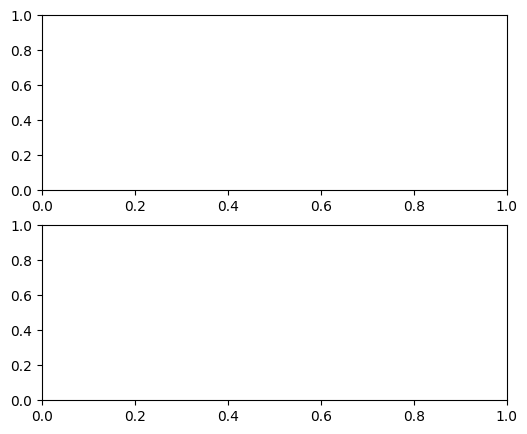

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,5))
ax1.plot(dtP, np.cumsum(s1P) / np.arange(len(s1P)), c='b', label='A')
ax1.plot(dtP, np.cumsum(s2P) / np.arange(len(s2P)), c='b', linestyle='--', label='B')
ax1.axvline(datetime.strptime('2020-01-01 12:00', '%Y-%m-%d %H:%M'), c='k', linestyle=':')
ax1.legend(frameon=False, fontsize=12)
# ax1.set_xticklabels([])
ax1.set_xlim([sensor_data_1_P['datetime'].iloc[0] - timedelta(seconds=10), t_datetime[-1] + timedelta(hours=1)])
myFmt = mdates.DateFormatter('%H')
ax1.xaxis.set_major_formatter(myFmt)
ax1.set_ylim([0, 0.6])

ax2.plot(dtF, np.cumsum(s1F) / np.arange(len(s1F)), c='r', label='A')
ax2.plot(dtF, np.cumsum(s2F) / np.arange(len(s2F)), c='r', linestyle='--', label='B')
ax2.axvline(datetime.strptime('2020-01-01 12:00', '%Y-%m-%d %H:%M'), c='k', linestyle=':')
ax2.legend(frameon=False, fontsize=12)
ax2.set_xlim([sensor_data_1_P['datetime'].iloc[0] - timedelta(seconds=10), t_datetime[-1] + timedelta(hours=1)])
myFmt = mdates.DateFormatter('%H')
ax2.xaxis.set_major_formatter(myFmt)
ax2.set_ylim([0, 0.6])
ax2.set_xlabel('Time (hr)', fontsize=14)

for axes in (ax1, ax2):
    axes.tick_params(labelsize=12)
    axes.set_ylabel('Sensor Mean (ft)', fontsize=14)

fig.tight_layout()
# fig.savefig(fig_savefp / 'stationarity.svg')

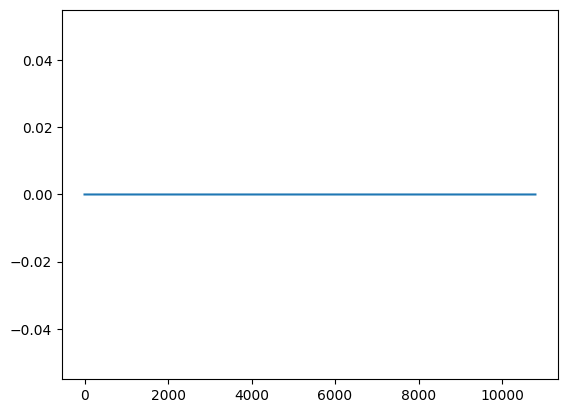

In [13]:
# Flooding.
flood_nodes = [38, 40, 42, 44, 46]

flooding = np.zeros((sensor_data_1_P_F.shape[0], len(flood_nodes)))
for i, flood_node in enumerate(flood_nodes):
    flooding[:,i] = sensor_data_1_P_F[f'Flood_node_{flood_node}'].to_numpy()

plt.plot(flooding[:,2])
plt.show()

### Fault severity and mean gap

In [42]:
upstream_link = 21
downstream_link = 48
variable = 'Depth'
fault_severities = np.arange(0, 1, 0.1)

# Fault-free measurements.
s1P = sensor_data_1_P[f'{variable}_link_{upstream_link}'].to_numpy()
s2P = sensor_data_1_P[f'{variable}_link_{downstream_link}'].to_numpy()
s1P_flow = sensor_data_1_P[f'Flow_link_{upstream_link}'].to_numpy()
s2P_flow = sensor_data_1_P[f'Flow_link_{downstream_link}'].to_numpy()

# Minimum depth threshold.
thresh = 0.04

mean_gap = np.zeros(len(fault_severities))
max_residual = np.zeros(len(fault_severities))
min_residual = np.zeros(len(fault_severities))
max_flow_residual = np.zeros(len(fault_severities))
min_flow_residual = np.zeros(len(fault_severities))
flooding = np.zeros(len(fault_severities))
for i, sev in enumerate(fault_severities):
    print(i, sev)
    phy_fault = [0.0, sev, 0.0, 0.0]

    # Save measured impulse to swmm.
    save_impulses_to_swmm(R1, t_datetime)

    # Weir values with no faults.
    sensor_data_1_P_F = run_model_with_constrictions(swmm_config_path, phy_fault, [upstream_link, downstream_link])

    s1F = sensor_data_1_P_F[f'{variable}_link_{upstream_link}'].to_numpy()
    s2F = sensor_data_1_P_F[f'{variable}_link_{downstream_link}'].to_numpy()
    s1F_flow = sensor_data_1_P_F[f'Flow_link_{upstream_link}'].to_numpy()
    s2F_flow = sensor_data_1_P_F[f'Flow_link_{downstream_link}'].to_numpy()

    # Maximum residual.
    max_residual[i] = np.max(s2P - s2F)
    min_residual[i] = np.min(s2P - s2F)
    max_flow_residual[i] = np.max(s2P_flow - s2F_flow)
    min_flow_residual[i] = np.min(s2P_flow - s2F_flow)

    # Thresholding. 
    idxF = (s1F > thresh) & (s2F > thresh)
    s1F = s1F[idxF]
    s2F = s2F[idxF]

    # Means.
    s1P_mean, s2P_mean = np.mean(s1P), np.mean(s2P)
    s1F_mean, s2F_mean = np.mean(s1F), np.mean(s2F)

    # Gap between means.
    mean_gap[i] = np.sqrt((s1P_mean - s1F_mean)**2 + (s2P_mean - s2F_mean)**2)

    # Total flooding.
    for _, flood_node in enumerate(flood_nodes):
        flooding[i] += np.sum(sensor_data_1_P_F[f'Flood_node_{flood_node}'].to_numpy())

0 0.0
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2020-01-01 00:00:00
Start Time: 2020-01-02 06:00:00
Removed Line: 14               38               39               100        0.03       0          0          0          0         

Removed Line: 14               CIRCULAR     1                0          0          0          1                    

Removed Line: 15               40               41               100        0.03       0          0          0          0         

Removed Line: 15               CIRCULAR     1                0          0          0          1                    

Removed Line: 16               42               43               100        0.03       0          0          0          0         

Removed Line: 16               CIRCULAR     1                0          0          0          1                    

Removed Line: 17               44               45               100        0.03       0          0          0          0         

Re

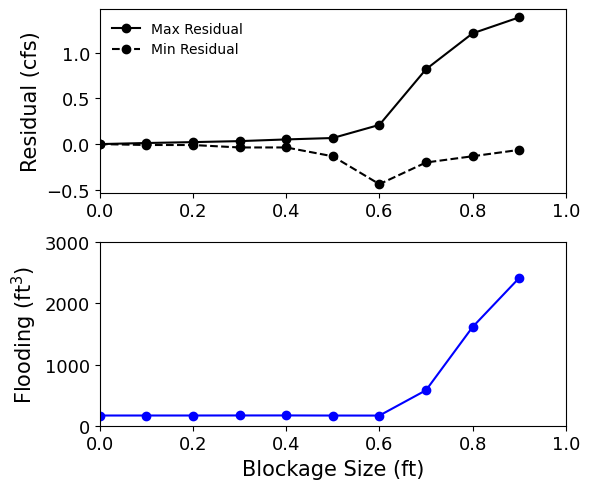

In [44]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5))
ax1.plot(fault_severities, max_flow_residual, 'k-o', label='Max Residual')
ax1.plot(fault_severities, min_flow_residual, 'k--o', label='Min Residual')
ax1.set_xlim([0, 1])
# ax1.set_ylim([0, 0.3])
# ax1.set_ylabel('Mean Gap (ft)', fontsize=15)
ax1.legend(frameon=False)
ax1.set_ylabel('Residual (cfs)', fontsize=15)
ax1.tick_params(labelsize=13)

ax2.plot(fault_severities, flooding, 'b-o')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 3000])
ax2.set_xlabel('Blockage Size (ft)', fontsize=15)
ax2.set_ylabel('Flooding ($\\rm ft^3$)', fontsize=15)
# ax2.set_yticks(np.arange(0, 1500, 250))
ax2.tick_params(labelsize=13)

fig.tight_layout()
# fig.savefig(fig_savefp / 'mean_gap_flooding.png', dpi=300)
fig.savefig(fig_savefp / 'max_flow_residual_flooding_R1.png', dpi=300)


Simulation info
Flow Units: CFS
System Units: US
Start Time: 2020-01-01 00:00:00
Start Time: 2020-01-02 06:00:00
Removed Line: 14               38               39               100        0.03       0          0          0          0         

Removed Line: 14               CIRCULAR     1                0          0          0          1                    

Removed Line: 15               40               41               100        0.03       0          0          0          0         

Removed Line: 15               CIRCULAR     1                0          0          0          1                    

Removed Line: 16               42               43               100        0.03       0          0          0          0         

Removed Line: 16               CIRCULAR     1                0          0          0          1                    

Removed Line: 17               44               45               100        0.03       0          0          0          0         

Removed 

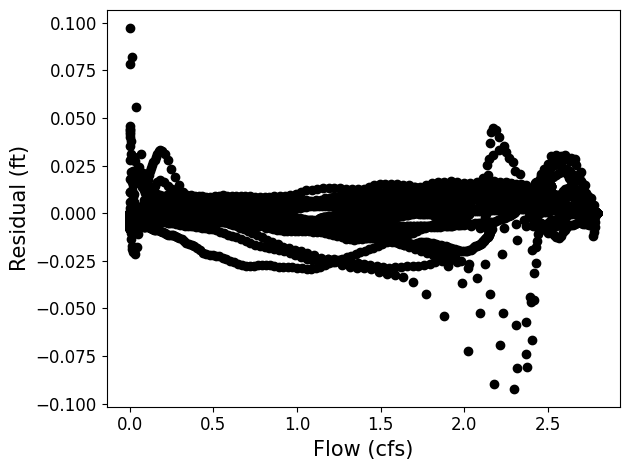

In [41]:
phy_fault = [0.0, 0.6, 0.0, 0.0]

# Weir values with no faults.
sensor_data_1_P_F = run_model_with_constrictions(swmm_config_path, phy_fault, [upstream_link, downstream_link])

s1F = sensor_data_1_P_F[f'{variable}_link_{upstream_link}'].to_numpy()
s2F = sensor_data_1_P_F[f'{variable}_link_{downstream_link}'].to_numpy()
s2F_flow = sensor_data_1_P_F[f'Flow_link_{downstream_link}'].to_numpy()

residuals = s2P - s2F

plt.scatter(s2F_flow, residuals, c='k')
plt.xlabel('Flow (cfs)', fontsize=15)
plt.ylabel('Residual (ft)', fontsize=15)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig(fig_savefp / 'flow_residual.png', dpi=300)
plt.show()

### Sliding window mean gap

In [353]:
def windowed_mean_divergence(Y_base, Y_test, k, thresh, skip=5):

    # Baseline trajectories.
    traj_b = extract_trajectories(Y_base, thresh)

    traj_list = []
    for _, traj in traj_b.items():
        # traj = traj / np.max(np.linalg.norm(traj, axis=1))
        # traj_list.append(traj)
        traj_list.append(np.max(traj, axis=0))
    traj_all_b = np.vstack(traj_list) if traj_list else np.array([])

    # Baseline mean.
    # y1b = Y_base[:,0]
    # y2b = Y_base[:,1]
    # tr_idx = (y1b > thresh) & (y2b > thresh)
    # y1b = y1b[tr_idx]
    # y2b = y2b[tr_idx]
    y1b_mean, y2b_mean = np.mean(traj_all_b, axis=0)# / len(traj_list)
    
    # Number of time stamps in test data.
    Nt = Y_test.shape[0]

    idx = list(range(0, Nt - k, skip))

    mean_gap = np.zeros(len(idx))
    print(mean_gap.shape)
    ytest_mean = np.zeros((len(idx), 2))
    for i, c in enumerate(idx):
        Yk = Y_test[c:c+k,:]
        # y1k = Yk[:,0]
        # y2k = Yk[:,1]
        # tr_idx = (y1k > thresh) & (y2k > thresh)
        # y1k = y1k[tr_idx]
        # y2k = y2k[tr_idx]

        # Baseline trajectories.
        traj_k = extract_trajectories(Yk, thresh)

        traj_list = []
        for _, traj in traj_k.items():
            # traj = traj / np.max(np.linalg.norm(traj, axis=1))
            # traj_list.append(traj)
            traj_list.append(np.max(traj, axis=0))
        traj_all_k = np.vstack(traj_list) if traj_list else np.array([])

        # Means.
        y1k_mean, y2k_mean = np.mean(traj_all_k, axis=0)# / len(traj_list)
        ytest_mean[i,0], ytest_mean[i,1] = y1k_mean, y2k_mean

        # Gap between means.
        mean_gap[i] = np.sqrt((y1b_mean - y1k_mean)**2 + (y2b_mean - y2k_mean)**2)

    return mean_gap, ytest_mean, np.stack([y1b_mean, y2b_mean]), idx


def orthogonal_distance(p1, p2, Y):
    """
    Computes the orthogonal distance from each row of Y to the line defined by points p1 and p2.

    Parameters:
    p1 (array-like): A point (x1, y1) defining the first point of the line.
    p2 (array-like): A point (x2, y2) defining the second point of the line.
    Y (numpy array): An (n,2) array where each row represents a point (x, y).

    Returns:
    numpy array: An array of distances from each point in Y to the line.
    """
    p1, p2 = np.array(p1), np.array(p2)
    Y = np.array(Y)

    # Line vector
    line_vec = p2 - p1

    # Compute the normal vector to the line
    normal_vec = np.array([-line_vec[1], line_vec[0]])

    # Compute distances using point-line distance formula
    distances = np.abs(np.dot(Y - p1, normal_vec)) / np.linalg.norm(normal_vec)
    
    return distances


In [359]:
# Run mean gap diagnosis on data.
def datetime_to_index(t_list, datetime_select):
    """
    Finds the index of the closest datetime in t_list to datetime_select.

    Parameters:
    t_list (list of datetime): A list of datetime objects.
    datetime_select (datetime): The target datetime to find the closest match.

    Returns:
    int: Index of the closest datetime in the list.
    """
    return min(range(len(t_list)), key=lambda i: abs(t_list[i] - datetime_select))

stationary_datetime = datetime.strptime('2020-01-02 00:00', '%Y-%m-%d %H:%M')
fault_datetime = datetime.strptime('2020-01-03 00:55', '%Y-%m-%d %H:%M')
stationary_idx = datetime_to_index(t_datetime, stationary_datetime)
fault_idx = datetime_to_index(t_datetime, fault_datetime)

# Data from models.
variable = 'Velocity'
YP = np.stack([sensor_data_1_P[f'{variable}_link_14'].to_numpy(), sensor_data_1_P[f'{variable}_link_18'].to_numpy()]).T
YF = np.stack([sensor_data_1_P_F[f'{variable}_link_14'].to_numpy(), sensor_data_1_P_F[f'{variable}_link_18'].to_numpy()]).T

# Make the data with a fault.
Y = YP
Y[fault_idx:] = YF[fault_idx:]

Y_base = Y[:stationary_idx]
Y_test = Y[stationary_idx:]

# Mean gap.
thresh = 0.04
k = stationary_idx
mean_gap, ytest_mean, ybase_mean, gap_idx = windowed_mean_divergence(Y_base, Y_test, k, thresh, skip=4)

(7020,)


In [360]:
# Orthogonal distances.
p1 = (0, 0)
p2 = (ybase_mean[0], ybase_mean[1])
dists = orthogonal_distance(p1, p2, ytest_mean)


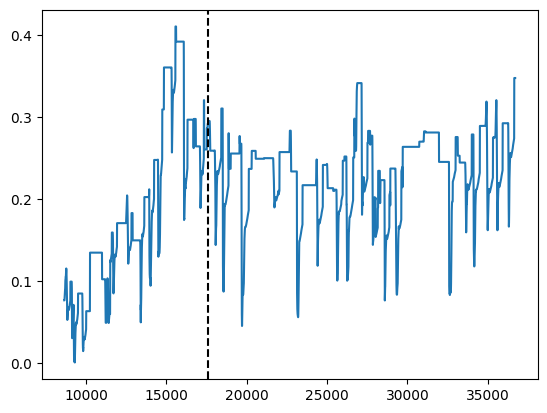

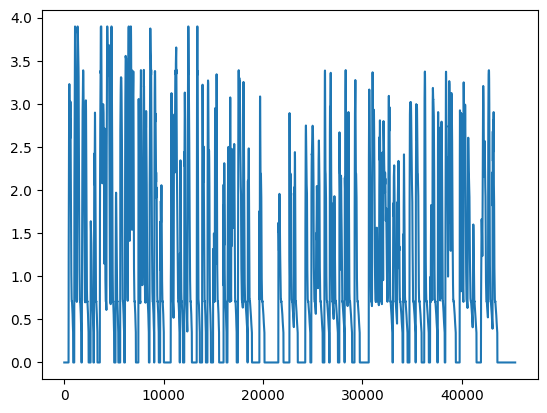

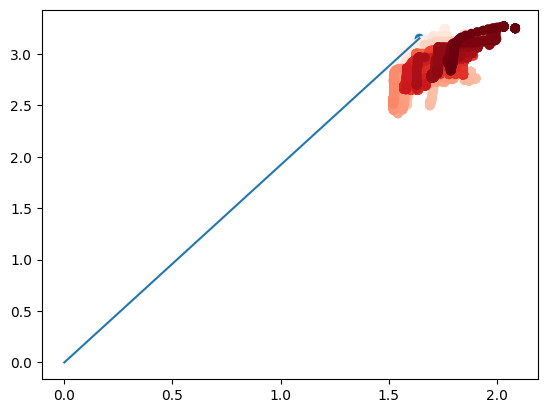

In [361]:
fig, ax = plt.subplots()
# ax.plot(np.array(gap_idx) + stationary_idx, mean_gap)
ax.plot(np.array(gap_idx) + stationary_idx, dists)
ax.axvline(fault_idx, c='k', linestyle='--')

fig, ax = plt.subplots()
ax.plot(Y[:,1])
# ax.axvline(stationary_idx, c='b', linestyle='--')
# ax.axvline(fault_idx, c='k', linestyle='--')

fig, ax = plt.subplots()
ax.scatter(ybase_mean[0], ybase_mean[1])
ax.scatter(ytest_mean[:,0], ytest_mean[:,1], c=np.arange(0,ytest_mean.shape[0]), cmap='Reds')
ax.plot([0, ybase_mean[0]], [0, ybase_mean[1]])


### Animation of inflow and sensor readings

c:\Users\ay434\Desktop\Python\urbansurge-env\lib\site-packages\matplotlib\animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


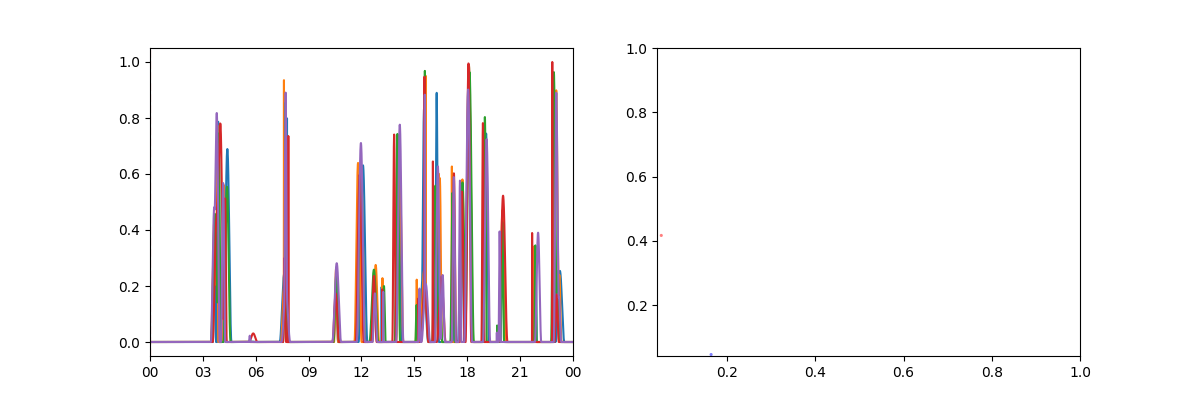

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

a11 = ax1.plot(t_datetime, R1)
a12 = ax1.axvline(t_datetime[0], c='r', linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=10)
myFmt = mdates.DateFormatter('%H')
ax1.xaxis.set_major_formatter(myFmt)
ax1.set_xlim([t_datetime[0], t_datetime[-1] + timedelta(seconds=10)]) 


a21 = ax2.scatter(s1P[0], s2P[0], s=5, c='b', alpha=0.5, edgecolors="None")
a22 = ax2.scatter(s1F[0], s2F[0], s=5, c='r', alpha=0.5, edgecolors="None")
ax2.set_xlim([thresh, 1])
ax2.set_ylim([thresh, 1])

def update(frame):
    # for each frame, update the data stored on each artist.
    # print(a12)
    # a12.set_xdata(t_datetime[frame])

    # update the scatter plot:
    a21_data = np.stack([s1P[:frame], s2P[:frame]]).T
    a22_data = np.stack([s1F[:frame], s2F[:frame]]).T
    a21.set_offsets(a21_data)
    a22.set_offsets(a22_data)

    return (a12, a21, a22)

# ani = animation.FuncAnimation(fig=fig, func=update, frames=100, interval=5)
# plt.show()

## Scattergraph

Simulation info
Flow Units: CFS
System Units: US
Start Time: 2020-01-01 00:00:00
Start Time: 2020-01-02 06:00:00


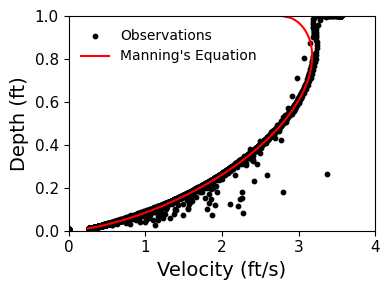

In [151]:
variable = 'Depth'
sensor_link = 64
sP_depth = sensor_data_1_P[f'{variable}_link_{sensor_link}'].to_numpy()
sF_depth = sensor_data_1_P_F[f'{variable}_link_{sensor_link}'].to_numpy()
concat_fault_data_depth = np.concatenate([sP_depth[:fault_start_idx], sF_depth[fault_start_idx:]])

variable = 'Velocity'
sP_velocity = sensor_data_1_P[f'{variable}_link_{sensor_link}'].to_numpy()
sF_velocity = sensor_data_1_P_F[f'{variable}_link_{sensor_link}'].to_numpy()
concat_fault_data_velocity = np.concatenate([sP_velocity[:fault_start_idx], sF_velocity[fault_start_idx:]])

# Expected from Manning's eq.
D = 1
d = np.linspace(0, D, 100)
n = 0.03
S = 0.02
swmm = swmm_model.SWMM(swmm_config_path)
v = manning_velocity(swmm, d, D, n, S)

fig, ax = plt.subplots(figsize=(4,3))
# ax.scatter(concat_fault_data_velocity, concat_fault_data_depth, c='k', facecolors='none', s=10, label='Observations')
ax.scatter(sP_velocity, sP_depth, c='k', facecolors='none', s=10, label='Observations')
# ax.scatter(sF_velocity, sF_depth, c='r', facecolors='none', s=10, label='Observations')
ax.plot(v, d, c='r', label='Manning\'s Equation')
ax.set_xlabel('Velocity (ft/s)', fontsize=14)
ax.set_ylabel('Depth (ft)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_xlim([0, 4])
ax.set_ylim([0, 1])
ax.legend(frameon=False, fontsize=10)
fig.tight_layout()
# fig.savefig(fig_savefp / 'scattergraph.png', dpi=300)

## Bayesian Optimization

In [ ]:
def optimal_fault_parameters(
        R: np.ndarray, 
        t_datetime: List, 
        ym: np.ndarray, 
        data_column: str,
        bounds: Dict[str, List[float]], 
        swmm_config_path: Path, 
        n_init: int,
        n_iter: int
) -> np.ndarray:
    """
    Find optimal fault parameters given observed depth, velocity, and flow.

    :param R: Observed runoff.
    :param ym: Observed depth, velocity, or flow.
    :param bounds: Bounds for the fault parameters. {upper: [List], lower: [List]}
    :param swmm_config_path: SWMM model configuration path.
    :param n_init: Number of initial samples for the Bayesian optimization procedure.
    :param n_iter: Number of iterations for the Bayesian optimization procedure.
    :return: Optimal fault parameter values.
    """
    # Save measured impulse to swmm.
    save_impulses_to_swmm(R, t_datetime)

    # Define the objective function to minimize the difference between observed and simulated data
    def objective_function(fault_vals: np.ndarray) -> float:
        sensor_data = run_model_with_constrictions(swmm_config_path, fault_vals)
        y_pred = sensor_data[data_column].to_numpy()
        return np.sum((y_pred - ym) ** 2)

    # Convert bounds to tensor
    lower_bounds = torch.tensor(bounds['lower'], dtype=torch.float64)
    upper_bounds = torch.tensor(bounds['upper'], dtype=torch.float64)

    # Initial sampling.
    train_x = torch.rand(n_init, len(lower_bounds), dtype=torch.float64)
    Y = torch.tensor([objective_function(train_x[i].numpy()) for i in range(n_init)], dtype=torch.float64).unsqueeze(1)

    for _ in range(n_iter):
        # Define the GP model
        gp = SingleTaskGP(train_x, Y)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_model(mll)

        # Define the acquisition function
        logEI = LogExpectedImprovement(gp, best_f=Y.max())

        # Optimize the acquisition function
        new_x, _ = optimize_acqf(
            logEI,
            bounds=torch.stack([lower_bounds, upper_bounds]),
            q=1,
            num_restarts=5,
            raw_samples=20,
        )

        # Evaluate the objective function at the new point
        new_y = torch.tensor([objective_function(new_x.numpy()[0])], dtype=torch.float64).unsqueeze(1)

        # Append the new data to the training set
        train_x = torch.cat([train_x, new_x], dim=0)
        Y = torch.cat([Y, new_y], dim=0)

    # Return the optimal values found
    return new_x.detach().numpy()

In [ ]:
# Measured runoff.
sig_t = 60 * 100
sig_m = 0.1
S, St = split_storms(R1, t)
Sp, Stp = perturb_storm_arrival(S, St, t, sig_t)
Sp, Stp = perturb_storm_magnitude(Sp, Stp, t, sig_m)
R1m = combine_storms(Sp, Stp, t)

# Measured depth, velocity, or flow in faulty system.
ym = sensor_data_1_P_F['Depth_link_18'].to_numpy()

# Ensemble of perturbed runoff.
n_ens = 10
R_ens = np.zeros((len(R1m), n_ens))
for i in range(n_ens):
    S, St = split_storms(R1m, t)
    Sp, Stp = perturb_storm_arrival(S, St, t, sig_t)
    Sp, Stp = perturb_storm_magnitude(Sp, Stp, t, sig_m)
    R_ens[:, i] = combine_storms(Sp, Stp, t)

# Parameter bounds.
bounds = {
    'upper': [0.9, 0.9, 0.9, 0.9],
    'lower': [0, 0, 0, 0]
}

# BayesOpt parameters.
n_init = 5 # Number of initialization samples.
n_iter = 50 # Number of BO iterations.

# Optimal fault parameters.
optimized_params = np.zeros((4, n_ens))
for i in range(n_ens):
    print('ENSEMBLE', i)
    optimized_params[:, i] = optimal_fault_parameters(R_ens[:, i], 
                                                      t_datetime, 
                                                      ym, 
                                                      'Depth_link_18', 
                                                      bounds, 
                                                      swmm_config_path,
                                                      n_init,
                                                      n_iter)


In [ ]:
print(optimized_params)

## CvM Detection

In [ ]:
# Impulse files corresponding to each node. {Node: Impulse filename}
impulse_files = {
    '46': 'R46',
    '44': 'R44',
    '42': 'R42',
    '40': 'R40',
    '38': 'R38',
}

for node, fname in impulse_files.items():
    flow_to_swmm_readable(R2m.flatten(), t_datetime, impulse_dir_P, f'{fname}.dat')

# Create instance of SWMM model.
swmm_M = SWMM(config_path_M)

# Configure model.
swmm_M.configure_model()

# Run model.
swmm_M.run_simulation()

# Sensor links.
sensor_links = [18]

# Sensor depth, velocity, and flow.
depth_M = swmm_M.get_link_depth()
velocity_M = swmm_M.get_link_velocity()
flow_M = swmm_M.get_link_flow()

# Set 'datetime' as index.
depth_M.set_index('datetime', inplace=True)
velocity_M.set_index('datetime', inplace=True)
flow_M.set_index('datetime', inplace=True)

# Concatenate along the column axis.
sensor_data_M = pd.concat([depth_M, velocity_M, flow_M], axis=1).reset_index()

# Model residuals and eCDF.
residuals2 = sensor_data_M['Depth_link_18'].to_numpy() - sensor_P_F['Depth_link_18'].to_numpy()
x_best2 = np.sort(residuals2.flatten())
y_best2 = np.arange(len(x_best2))/float(len(x_best2))

In [ ]:
# Compute Cramer-von Mises statistic for second storm set and fault.
# Interpolating to a common set of x-values
x_common = np.union1d(x_best, x_best2)
y_best_interp = np.interp(x_common, x_best, y_best)
y_best2_interp = np.interp(x_common, x_best2, y_best2)

# Compute CvM statistic: Integral of squared difference
CvM2 = np.trapz((y_best_interp - y_best2_interp) ** 2, x_common)

plt.figure(figsize=(5,3))
plt.hist(CvM, bins=31, density=True)
# plt.scatter(CvM, np.zeros(CvM.size), marker='|', c='k', s=200)
plt.vlines(CvM, 0, 500, colors='k', lw=0.5)
plt.axvline(CvM2, c='r', lw=1.5)
# plt.xlim(0, 0.0006)
plt.xlabel('CvM Statistic', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.savefig(fig_savefp / 'CvM_statistic_fault.png', dpi=300)

### Configurations

### Impulses

In [ ]:
# Impulse directory.
impulse_dir_M = Path(r'C:\Users\ay434\Documents\urbansurge\analysis\lab_system\precipitation\precip_data')

# Impulse files corresponding to each node. {Node: Impulse filename}
impulse_files_M = {
    '46': 'R46m',
    '44': 'R44m',
    '42': 'R42m',
    '40': 'R40m',
    '38': 'R38m'
}

### Configure model

In [ ]:
# SWMM model configuration file. 
config_path_M = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\lab_weirs_config.yml"

# Create instance of SWMM model.
swmm_M = SWMM(config_path_M)

# Configure model.
swmm_M.configure_model()

# Run model.
swmm_M.run_simulation()

### Sensor data

In [ ]:
# Sensor links.
sensor_links = [18]

# Sensor depth, velocity, and flow.
depth_M = swmm_M.get_link_depth()
velocity_M = swmm_M.get_link_velocity()
flow_M = swmm_M.get_link_flow()

# Set 'datetime' as index.
depth_M.set_index('datetime', inplace=True)
velocity_M.set_index('datetime', inplace=True)
flow_M.set_index('datetime', inplace=True)

# Concatenate along the column axis.
sensor_data_M = pd.concat([depth_M, velocity_M, flow_M], axis=1).reset_index()

plt.figure(figsize=(5,3))
plt.plot(sensor_data_M['datetime'], sensor_data_M.loc[:, [f'Flow_link_{sl}' for sl in sensor_links]])
plt.legend(sensor_links, frameon=False)
plt.show()

## Residuals

In [ ]:
# Manning's equation.
def manning_velocity(swmm, d, D, n, S):
    Rh = swmm.get_link_circular_Rh(d, D)
    v = (1 / n) * S**(1 / 2) * Rh**(2 / 3)

    return v


In [ ]:
sensor_link = 18
D = 0.25
d = np.linspace(0, D, 100)
n = 0.01
S = 0.02
v = manning_velocity(swmm_M, d, D, n, S)

fig, ax = plt.subplots()
ax.scatter(sensor_P_NF.loc[:, [f'Velocity_link_{sensor_link}']].to_numpy(), sensor_P_NF.loc[:, [f'Depth_link_{sensor_link}']].to_numpy(), facecolor='None', edgecolors='k')
ax.scatter(sensor_P_F.loc[:, [f'Velocity_link_{sensor_link}']].to_numpy(), sensor_P_F.loc[:, [f'Depth_link_{sensor_link}']].to_numpy(), c='k', marker='x')
ax.plot(v, d, 'r')

In [ ]:
# Sensor link.
sensor_link = 18

# State variable.
state_var = 'Depth'

# Residuals.
sensor_P_NF_ar = sensor_P_NF.loc[:, [f'{state_var}_link_{sensor_link}']].to_numpy()
sensor_P_F_ar = sensor_P_F.loc[:, [f'{state_var}_link_{sensor_link}']].to_numpy()
sensor_M = sensor_data_M.loc[:, [f'{state_var}_link_{sensor_link}']].to_numpy()
residuals_NF = sensor_M - sensor_P_NF_ar
residuals_F = sensor_M - sensor_P_F_ar
# residuals = residuals[sensor_P > 0.05] 

# mean_res = np.mean(residuals)
# lower_error = mean_res - np.min(residuals)
# upper_error = np.max(residuals) - mean_res

fig, ax = plt.subplots()
ax.plot(sensor_P_NF_ar, label='No Fault')
ax.plot(sensor_P_F_ar, label='Fault')
ax.plot(sensor_M, 'k:', label='Model')
ax.set_xlim(2000, 4000)
ax.legend(frameon=False)

fig, ax = plt.subplots(figsize=(4,3))
# ax.errorbar(0, mean_res, yerr=[[lower_error], [upper_error]], fmt='ko', capsize=5, ecolor='k')
# i = 0
# ax.scatter(np.random.uniform(i - 0.2, i + 0.2, len(residuals_NF)), residuals_NF, facecolor='None', edgecolors='k')
# i = 1
# ax.scatter(np.random.uniform(i - 0.2, i + 0.2, len(residuals_F)), residuals_F, facecolor='None', edgecolors='k')

# ax.hist(residuals_NF, bins=31, alpha=0.5)
# ax.hist(residuals_F, bins=31, alpha=0.5)

x_NF = np.sort(residuals_NF.flatten())
y_NF = np.arange(len(x_NF))/float(len(x_NF))
x_F = np.sort(residuals_F.flatten())
y_F = np.arange(len(x_F))/float(len(x_F))
ax.set_ylim(0, 1)
ax.set_xlim(-0.02, 0.03)
ax.plot(x_NF, y_NF, label='No Fault')
ax.plot(x_F, y_F, label='Fault')
ax.legend(frameon=False, fontsize=12)
ax.set_xlabel('Residual (ft)', fontsize=14)
ax.set_ylabel('Fraction', fontsize=14)
ax.tick_params(labelsize=12)

fig.tight_layout()
fig.savefig(fig_savefp / 'residual_ecdf.png', dpi=300)

# ax.boxplot(residuals)
# ax.hist(residuals, bins=31)
# ax.set_yscale('log')
# ax.set_xlim(0, 2000)
# ax.set_ylim(-0.006, 0.0125)



In [ ]:
def hydrograph_recession(t, y):
    dt = t[1] - t[0]
    dydt = (y[1:] - y[:-1]) / dt

    # Retain points where difference is negative (recession).
    dydt_neg = dydt < 0

    # Clip y to same length as dydt.
    y = y[:-1]

    return y[dydt_neg], dydt[dydt_neg]

In [ ]:
sensor_link = 18

flow_P_NF = sensor_P_NF.loc[:, f'Flow_link_{sensor_link}'].to_numpy()
flow_P_F = sensor_P_F.loc[:, f'Flow_link_{sensor_link}'].to_numpy()
flow_M = sensor_data_M.loc[:, f'Flow_link_{sensor_link}'].to_numpy()

Q_P_NF, dQ_P_NF = hydrograph_recession(np.arange(len(flow_P_NF)), flow_P_NF)
Q_P_F, dQ_P_F = hydrograph_recession(np.arange(len(flow_P_F)), flow_P_F)
Q_M, dQ_M = hydrograph_recession(np.arange(len(flow_M)), flow_M)

depth_P_NF = sensor_P_NF.loc[:, f'Depth_link_{sensor_link}'].to_numpy()
depth_P_F = sensor_P_F.loc[:, f'Depth_link_{sensor_link}'].to_numpy()
depth_M = sensor_data_M.loc[:, f'Depth_link_{sensor_link}'].to_numpy()

H_P, dH_P = hydrograph_recession(np.arange(len(depth_P)), depth_P)
H_M, dH_M = hydrograph_recession(np.arange(len(depth_M)), depth_M)

fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(Q_P_NF, dQ_P_NF, marker='x', label='Observed NF')
ax.scatter(Q_P_F, dQ_P_F, marker='x', label='Observed F')
ax.scatter(Q_M, dQ_M, c='k', marker='x', label='Modeled')
ax.set_xlabel('Q (cfs)', fontsize=14)
ax.set_ylabel('dH/dt', fontsize=14)
ax.tick_params(labelsize=12)
ax.legend(fontsize=12, frameon=False)

fig.tight_layout()
# fig.savefig(fig_savefp / 'H_dH_baseline.png', dpi=300)

## Unused code

### Falling limb plotting

In [ ]:
# Extract the falling limbs.
falling_limbs_P = extract_recessions(sP, norm=True)
falling_limbs_F = extract_recessions(sF, norm=True)

nsamp = 20
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
limb_mean = np.zeros(nsamp)
c = 0
for peak, limb in falling_limbs_P.items():
    if len(limb) > 20:
        idx = np.round(np.linspace(0, len(limb) - 1, nsamp)).astype(int)
        ax2.plot(np.max(limb[idx]) - limb[idx], c='k', alpha=0.3, linewidth=1)
        # ax.scatter(limb[round(len(limb) * 0.25)], limb[round(len(limb) * 0.75)], c='k')
        limb_mean += np.max(limb[idx]) - limb[idx]
        c += 1
limb_mean /= c
ax1.plot(limb_mean, c='#000103', linewidth=2)

c = 0
limb_mean = np.zeros(nsamp)
for peak, limb in falling_limbs_F.items():
    if len(limb) > 20:
        idx = np.round(np.linspace(0, len(limb) - 1, nsamp)).astype(int)
        ax2.plot(np.max(limb[idx]) - limb[idx], c='b', alpha=0.3, linewidth=1)
        limb_mean += np.max(limb[idx]) - limb[idx]
        c += 1
        # ax.scatter(limb[round(len(limb) * 0.25)], limb[round(len(limb) * 0.75)], c='b')
limb_mean /= c
ax1.plot(limb_mean, c='#0062ff', linewidth=2)

### CvM statistic

In [ ]:
# Compute Cramer-von Mises statistic for different precipitation perturbations.
# Split storms.
S, St = split_storms(R1m, t)

Ng = 15
Sig_t = np.linspace(1, 200, Ng)
Sig_m = np.linspace(0.001, 0.2, Ng)
CvM = np.zeros(Ng**2)
for i in range(Ng):
    for j in range(Ng):
        print(i*Ng + j)
        sig_t = 60 * Sig_t[i]
        sig_m = Sig_m[j]
        Sp, Stp = perturb_storm_arrival(S, St, t, sig_t)
        Sp, Stp = perturb_storm_magnitude(Sp, Stp, t, sig_m)
        Rp = combine_storms(Sp, Stp, t)

        # Impulse files corresponding to each node. {Node: Impulse filename}
        impulse_files = {
            '46': 'R46',
            '44': 'R44',
            '42': 'R42',
            '40': 'R40',
            '38': 'R38',
        }

        for node, fname in impulse_files.items():
            flow_to_swmm_readable(Rp.flatten(), t_datetime, impulse_dir_P, f'{fname}.dat')

        # Run model.
        swmm_M.run_simulation()

        # Sensor links.
        sensor_links = [18]

        # Sensor depth, velocity, and flow.
        sensor_data_M = swmm_M.get_link_depth()
        
        # Model residuals and eCDF.
        residuals = sensor_data_M['Depth_link_18'].to_numpy() - sensor_data_P['Depth_link_18'].to_numpy()
        x_res = np.sort(residuals.flatten())
        y_res = np.arange(len(x_res))/float(len(x_res))

        # Interpolating to a common set of x-values
        x_common = np.union1d(x_best, x_res)
        y_best_interp = np.interp(x_common, x_best, y_best)
        y_res_interp = np.interp(x_common, x_res, y_res)

        # Compute CvM statistic: Integral of squared difference
        cvm_statistic = np.trapz((y_best_interp - y_res_interp) ** 2, x_common)
        
        CvM[i*Ng + j] = cvm_statistic

plt.figure(figsize=(5,3))
plt.hist(CvM, bins=31, density=True)
# plt.scatter(CvM, np.zeros(CvM.size), marker='|', c='k', s=200)
plt.vlines(CvM, 0, 500, colors='k', lw=0.5)
plt.xlim(0, 0.0012)
plt.xlabel('CvM Statistic', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
# plt.savefig(fig_savefp / 'CvM_statistic.png', dpi=300)